In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
from UnarySim.sw.kernel.sqrt import UnarySqrt
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time
import math
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rng = "Sobol"

tensor([[0.4902, 0.6719, 0.5137,  ..., 0.7803, 0.7451, 0.8740]],
       device='cuda:0')
7
--- 1.1580116748809814 seconds ---
input error:  tensor(-0.0020, device='cuda:0') tensor(0.0020, device='cuda:0')
output error:  tensor(-0.0024, device='cuda:0') tensor(0.1875, device='cuda:0')
input: tensor([[0.4902, 0.6719, 0.5137,  ..., 0.7803, 0.7451, 0.8740]],
       device='cuda:0')
output: tensor([[0.7002, 0.8197, 0.7167,  ..., 0.8833, 0.8632, 0.9349]],
       device='cuda:0')
output pp:  Parameter containing:
tensor([[0.7500, 0.8438, 0.7578,  ..., 0.8906, 0.8711, 0.9375]],
       device='cuda:0')
RMSE 0.07245598619916264
MAE 0.048359703
bias 0.048165277


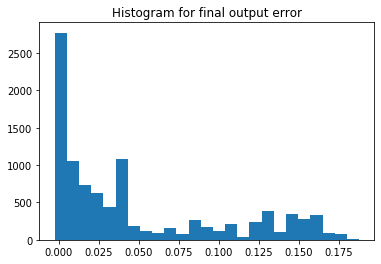

tensor([[0.3086, 0.8477, 0.9326,  ..., 0.3965, 0.3760, 0.3057]],
       device='cuda:0')
7
--- 1.4870119094848633 seconds ---
input error:  tensor(-0.0039, device='cuda:0') tensor(0.0039, device='cuda:0')
output error:  tensor(-0.0634, device='cuda:0') tensor(0.1008, device='cuda:0')
input: tensor([[0.3086, 0.8477, 0.9326,  ..., 0.3965, 0.3760, 0.3057]],
       device='cuda:0')
output: tensor([[0.5555, 0.9207, 0.9657,  ..., 0.6297, 0.6132, 0.5529]],
       device='cuda:0')
output pp:  Parameter containing:
tensor([[0.6016, 0.9219, 0.9609,  ..., 0.7266, 0.7109, 0.5859]],
       device='cuda:0')
RMSE 0.04038102942080855
MAE 0.028468305
bias 0.023459785


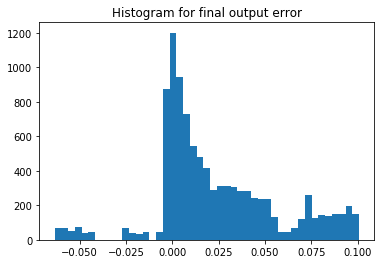

In [4]:
col = 10000
modes = ["unipolar", "bipolar"]
static = True
bitwidth = 8
bstype = torch.float
randtype = torch.float
jk_trace = False
emit = True
depth_emit = 3
for mode in modes:
    input = torch.rand(1, col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
    if emit is True:
        input = (torch.rand(1, col).mul(2**bitwidth).round().div(2**bitwidth)*0.75+0.25).to(device)
    print(input)
    
    dut_sqrt = UnarySqrt(mode=mode, jk_trace=jk_trace, depth=4, rng="Sobol", rng_dim=4, emit=emit, depth_emit=depth_emit, bstype=torch.float).to(device)

    output = torch.sqrt(input).to(device)

    outPE = ProgressiveError(output, mode=mode).to(device)

    inputPE = ProgressiveError(input, mode=mode).to(device)
    inputSRC = SourceGen(input, bitwidth, mode=mode, randtype=randtype)().to(device)
    inputRNG = RNG(bitwidth, 1, rng, randtype)().to(device)
    inputBS = BSGen(inputSRC, inputRNG, bstype).to(device)
    
    with torch.no_grad():
        start_time = time.time()
        for i in range(2**bitwidth):
            input_bs = inputBS(torch.tensor([i]))
            inputPE.Monitor(input_bs)

            out_bs = dut_sqrt(input_bs)
            outPE.Monitor(out_bs)
        print("--- %s seconds ---" % (time.time() - start_time))
        print("input error: ", torch.min(inputPE()[1]), torch.max(inputPE()[1]))
        
        print("output error: ", torch.min(outPE()[1]), torch.max(outPE()[1]))
        
        
        print("input:", input)
        print("output:", output)
        print("output pp: ", outPE()[0])

        result_pe = outPE()[1].view(-1).cpu().numpy()
        print("RMSE", math.sqrt(sum(result_pe**2)/len(result_pe)))
        print("MAE", np.mean(np.abs(result_pe)))
        print("bias", np.mean(result_pe))
        fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
        plt.title("Histogram for final output error")
        plt.show()